In [ ]:
import torch

from torchvision.models import inception_v3, Inception_V3_Weights
import torch.nn as nn
from torchvision.transforms import (
    Compose,
    ToTensor,
    Normalize,
    Resize,
    RandomHorizontalFlip,
    RandomVerticalFlip,
)
from torchvision.datasets import ImageFolder

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from classification_model import ClassificationModelBuilding
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
import torch.optim as optim
from torchvision.transforms import functional as TF

import os
import fnmatch
import random

from torch.optim.lr_scheduler import ReduceLROnPlateau
from Focal_Loss import FocalLoss

In [2]:
class RandomRightRotation:
    def __init__(self, angles=[0, 90, 180, 270]):
        self.angles = angles

    def __call__(self, img):
        angle = random.choice(self.angles)
        return TF.rotate(img, angle)

In [ ]:
train_root_dir = "../data/skin_cancer_train"
val_root_dir = "../data/skin_cancer_val"

device = "cuda" if torch.cuda.is_available() else "cpu"

class_counts = {}

for class_name in os.listdir(train_root_dir):
    class_path = os.path.join(train_root_dir, class_name)
    if os.path.isdir(class_path):
        num_jpgs = len(fnmatch.filter(os.listdir(class_path), "*.jpg"))
        class_counts[class_name] = num_jpgs

label_to_idx = {"benign": 0, "malignant": 1}
class_weight = {label_to_idx[label]: 1 / count for label, count in class_counts.items()}
class_weight

{0: 0.0001030290541932825, 1: 0.003401360544217687}

In [ ]:
# Transformation to be applied to positive classes
pos_data_transform = Compose(
    [

        Resize(299),
        ToTensor(),
        Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        RandomHorizontalFlip(p=0.5),
        RandomVerticalFlip(p=0.5),
        RandomRightRotation(angles=[90, 180, 270]),
    ]
)
# Transformation to be applied to negative classes
base_transform = Compose(
    [Resize(299), ToTensor(), Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]
)

# Load untransformed train data
raw_train = ImageFolder(root=train_root_dir, transform=None)

In [5]:
class ConditionalAugDataset(Dataset):
    def __init__(self, base_dataset, pos_transform, base_transform):
        self.dataset = base_dataset
        self.pos_transform = pos_transform
        self.base_transform = base_transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]

        if label == 1:
            img = self.pos_transform(img)
        else:
            img = self.base_transform(img)
        return img, label

In [6]:
gen = torch.Generator()
gen.manual_seed(42)

sample_weight = [class_weight[lb] for lb in raw_train.targets]

sampler = WeightedRandomSampler(
    sample_weight, num_samples=len(sample_weight), replacement=True, generator=gen
)

In [ ]:
train_dataset = ConditionalAugDataset(
    raw_train,
    pos_data_transform,
    base_transform,
)
val_dataset = ImageFolder(root=val_root_dir, transform=base_transform)


train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)


val_loader = DataLoader(val_dataset, batch_size=32)

In [8]:
model = inception_v3(weights=Inception_V3_Weights.DEFAULT)
model

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [9]:
model.fc = nn.Linear(model.fc.in_features, 1)
model

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [10]:
torch.manual_seed(13)
loss_fn = nn.BCEWithLogitsLoss()
# loss_fn = FocalLoss(alpha=0.75, gamma=1)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, "min", factor=0.1, patience=3)

built_model = ClassificationModelBuilding(
    model, loss_fn, optimizer, train_loader, val_loader, scheduler
)
built_model.fit(epochs=15)

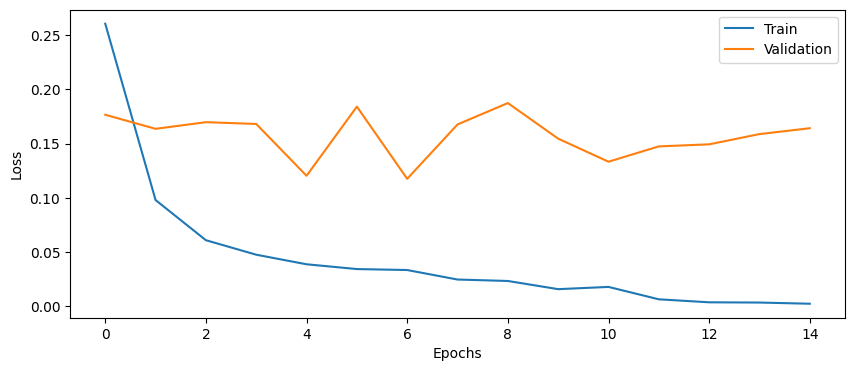

In [11]:
fig = built_model.plot_losses()

In [12]:
val_preds = []
true_labels = []

for x_batch, y_batch in val_loader:
    preds = built_model.predict(x_batch)
    true_labels.extend(y_batch)
    val_preds.extend(preds)

val_preds = np.array(val_preds)

thresholds = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

results = []

for threshold in thresholds:
    pred = (val_preds >= threshold).astype(int)

    acc = accuracy_score(true_labels, pred)
    precision = precision_score(true_labels, pred)
    recall = recall_score(true_labels, pred)
    f1 = f1_score(true_labels, pred)

    results.append(
        {
            "threshold": threshold,
            "accuracy": acc,
            "precision": precision,
            "recall": recall,
            "F1 score": f1,
        }
    )

df_result = pd.DataFrame(results)
df_result.sort_values(by="recall", ascending=False)

,threshold,accuracy,precision,recall,F1 score
0,0.2,0.970,0.812500,0.866667,0.838710
1,0.3,0.973,0.838710,0.866667,0.852459
2,0.4,0.976,0.875000,0.855556,0.865169
3,0.5,0.978,0.895349,0.855556,0.875000
4,0.6,0.977,0.894118,0.844444,0.868571
5,0.7,0.977,0.894118,0.844444,0.868571
6,0.8,0.978,0.904762,0.844444,0.873563


In [ ]:
test_root_dir = "../data/skin_cancer_test"
test_dataset = ImageFolder(root=test_root_dir, transform=base_transform)
test_loader = DataLoader(test_dataset, batch_size=32)

test_preds = []
test_labels = []
for x_batch, y_batch in test_loader:
    preds = built_model.predict(x_batch)
    test_preds.extend(preds)
    test_labels.extend(y_batch)

test_preds = np.array(test_preds)

pred_labels = (test_preds >= 0.3).astype(int)

acc = accuracy_score(test_labels, pred_labels)
precision = precision_score(test_labels, pred_labels)
recall = recall_score(test_labels, pred_labels)
f1 = f1_score(test_labels, pred_labels)

print(f"Accuracy is {acc:.4f}")
print(f"Precision is {precision:.4f}")
print(f"Recall is {recall:.4f}")
print(f"F1 score is {f1:.4f}")

Accuracy is 0.9660
Precision is 0.7917
Recall is 0.8444
F1 score is 0.8172
